In [30]:
scan_directory = "/home/novac/Desktop/qv3d-automation/qv3d-data/simulation-emitScan"
file_number = 11 # synchrotron file you want to analyze: usually the last one
fontsize = 14
screen_position = 11 #m from the begining of plasma cell

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.integrate import simps
from scipy.constants import c, pi, e, m_e, epsilon_0

import sys       
sys.path.append('/home/novac/Desktop/qv3d-automation/pyScripts')
from particles import getParameters, calculateParameters

### select synchrotron file number (file_number=11; the last file) in scan directory

In [20]:
if file_number < 10:
    file_name = 'v3d_synchrotron_0000' + str(file_number) + '.h5'
elif file_number < 100:
    file_name = 'v3d_synchrotron_000' + str(file_number) + '.h5'
elif file_number < 1000:
    file_name = 'v3d_synchrotron_00' + str(file_number) + '.h5'
else:
    print('ERROR: check the file_number.')

# Get the parent directory
parent_directory = os.path.abspath(os.path.join(scan_directory, os.pardir))
parent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
synchrotron_dotpy = os.path.join(parent_directory, 'pyScripts', 'synchrotron.py')
em_dotpy = os.path.join(parent_directory, 'pyScripts', 'em.py')


# List all folders in the directory
folders = [name for name in os.listdir(scan_directory) if os.path.isdir(os.path.join(scan_directory, name))]
folders = sorted(folders, key=lambda x: int(x.split('-')[1]))
#folders = sorted(folders)

#print("Sorted Folders:", folders)
synch_files = []
for folder in folders:
    file_path = os.path.join(scan_directory, folder, file_name)
    synch_files.append(file_path)
    #print(file_path)

In [23]:
DL_radii = np.array([])
for folder in folders:
    file_path = os.path.join(scan_directory, folder, 'v.ini')    
    with open(file_path, "r") as file:
        # Flag to indicate when to start parsing RadiusY
        start_parsing = False

        # Read each line in the file
        for line in file:
            line = line.split("#")[0].strip()

            # Check if the line contains "&Specie2"
            if "&Specie2" in line:
                # Set flag to start parsing RadiusY
                start_parsing = True
            elif start_parsing and "RadiusY" in line:
                # Parse RadiusY value
                radius_y = float(line.split("=")[1].strip())
                # Stop parsing
                start_parsing = False
                # Print or use the value
                #print("RadiusY after &Specie2:", radius_y)
                DL_radii = np.append(DL_radii, radius_y)


## Functions to calculate photons numbers

In [24]:
# ###############################################################################
def integrate_array_with_respect_to_array(array1, array2, start_index, end_index):
    """
    Integrate array1 with respect to array2 between two specified indices using Simpson's rule.

    Parameters:
        array1 (array-like): Array of values to integrate.
        array2 (array-like): Array of values with respect to which integration is performed.
        start_index (int): Start index for integration.
        end_index (int): End index for integration.

    Returns:
        float: Integral of array1 with respect to array2 between the specified indices.
    """
    # Slice the arrays between start and end indices
    array1_slice = array1[start_index:end_index+1]
    array2_slice = array2[start_index:end_index+1]

    # Perform numerical integration using Simpson's rule
    integral = simps(array1_slice, array2_slice)

    return integral

# ############################################
def plot_spectrum_regions(Nphotons_Energy, Energy):
    x_initenergy = 124 #eV
    uv_initenergy = 3.1 #eV

    # Calculate all photons
    start_index = 0            # Start index for integration
    end_index = len(Energy)    # End index for integration
    all_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, start_index, end_index)
    #print('ALL photons number: ', (all_photons))
    #print('ALL photons number: ', "{0:.1E}".format(all_photons))

    for i in range(end_index):
        if Energy[i] >= uv_initenergy:
            uv_index = i
            break
    for i in range(end_index):
        if Energy[i] >= x_initenergy:
            x_index = i
            break
    low_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, start_index, uv_index)
    #print('Low energy photons number (', "{0:.1f}".format(Energy[start_index]), '-', "{0:.1f}".format(Energy[uv_index-1]), ' eV): ', "{0:.1E}".format(low_photons))

    uv_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, uv_index, x_index-1)
    #print('UV photons number (', "{0:.1f}".format(Energy[uv_index]), '-', "{0:.1f}".format(Energy[x_index-1]), ' eV): ', "{0:.1E}".format(uv_photons))

    x_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, x_index, end_index)
    #print('X-ray photons number (', "{0:.1f}".format(Energy[x_index]), '-', "{0:.1f}".format(Energy[end_index-1]), ' eV): ', "{0:.1E}".format(x_photons))
    
    return all_photons, x_photons, uv_photons, low_photons

# Scan over all folders $\rightarrow$ Calculate synchrotron and particle parameters

In [25]:
criticalEnergys  = []
Nphotons_Energy  = []
Nphotons_Theta   = []
Nphotons_Phi     = []
Energys          = []
Thetas           = []
Phis             = []
phases           = []
meanThetas       = []
sigmaThetas      = []

all_photons      = []
x_photons        = []
uv_photons       = []
low_photons      = []

energys = np.array([])
energySpreads = np.array([])
dists = np.array([])
charges = np.array([])
emittances = np.array([])

for file in synch_files:
    #print(file, end="\r")
    
    # Get the synchrotron data
    # ########################
    synch = !python {synchrotron_dotpy} {file}
    
    my_dict = eval(synch[0])
    # Convert NumPy arrays
    for key, value in my_dict.items():
        if isinstance(value, np.ndarray):
            my_dict[key] = value.tolist()
            
    criticalEnergy = my_dict['criticalEnergy']
    Nphoton_Energy = my_dict['Nphoton_Energy']
    Nphoton_Theta  = my_dict['Nphoton_Theta']
    Nphoton_Phi    = my_dict['Nphoton_Phi']
    Energy          = my_dict['Energy']
    Theta           = my_dict['Theta']
    Phi             = my_dict['Phi']
    phase           = my_dict['phase']
    
    all_photon, x_photon, uv_photon, low_photon = plot_spectrum_regions(Nphoton_Energy, Energy)
    
    criticalEnergys.append(criticalEnergy)
    Nphotons_Energy.append(Nphoton_Energy)
    Nphotons_Theta.append(Nphoton_Theta)
    Nphotons_Phi.append(Nphoton_Phi)
    Energys.append(Energy)
    Thetas.append(Theta)
    Phis.append(Phi)
    phases.append(phase)#          = np.vstack(phase)   
    
    meanTheta = np.average(Theta,weights=Nphoton_Theta)
    sigmaTheta = np.average((Theta - meanTheta)**2, weights=Nphoton_Theta)
    sigmaTheta = np.sqrt(sigmaTheta)
    meanThetas.append(meanTheta)
    sigmaThetas.append(sigmaTheta)
    
    all_photons.append(all_photon)
    x_photons.append(x_photon)
    uv_photons.append(uv_photon)
    low_photons.append(low_photon)
    
    
    # Get the particles data
    # ######################    
    simulation_directory = os.path.dirname(file)
    print(simulation_directory, end="\r")
    witness_values = !python {em_dotpy} -ol {simulation_directory} {11} 2
    driver_values = !python {em_dotpy} -ol {simulation_directory} {11} 1
    phase, wmg, stdev_g, W, lamdap, emittance, lamdap=getParameters(witness_values[0])
    energy, energySpread, dist, charge = calculateParameters(phase,wmg,stdev_g,W,lamdap)
    energys  = np.append(energys, energy)
    energySpreads = np.append(energySpreads, energySpread)
    dists = np.append(dists, dist)
    charges = np.append(charges, charge)
    emittances = np.append(emittances, emittance)
    
    
    # Calculate initial radius of beam
    ##################################
    kp = 2 * pi/lamdap
    radii = DL_radii / np.sqrt(2) / kp

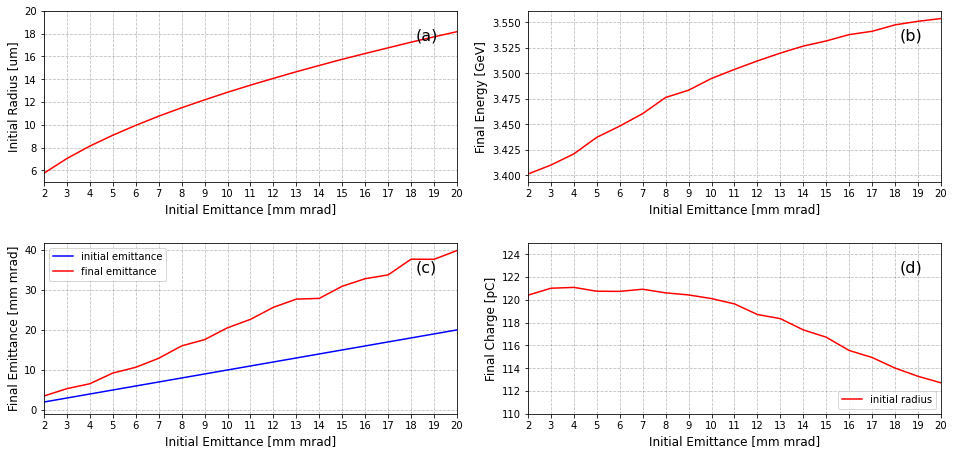

In [48]:
initial_emittance = list(range(1, 21))

fontsize = 12
fig, axs = plt.subplots(2, 2, figsize=(14, 7))
fig.tight_layout(pad=4.)

ax = axs[1, 0]
###########
ax.plot(initial_emittance, initial_emittance, c='b', label='initial emittance')
ax.plot(initial_emittance, emittances, c='r', label='final emittance')
#ax.plot(driverDist*100, driverEnergy/1e6, c='b', label='driver')
    #ax.set_xlim(0,25)
    #ax.set_ylim(0, 500)
ax.set_xlabel('Initial Emittance [mm mrad]', fontsize=fontsize)
ax.set_ylabel('Final Emittance [mm mrad]', fontsize=fontsize)
    #ax.set_xticks(range(0, 26, 5))
    #ax.set_yticks(range(0, 501, 100))
ax.set_xlim(2, 20)
ax.set_xticks(range(2, 21))

#ax.set_ylim(2, 20)
#ax.set_yticks(range(2, 21))

ax.legend(loc='upper left')
ax.grid(True, linestyle='--', color='gray', alpha=0.5)
ax.text(0.9, 0.9, '(c)', transform=ax.transAxes, fontsize = 16, va='top', color='k')

ax = axs[0, 1]
###########
ax.plot(initial_emittance, energys/1e9, c='r')
#ax.plot(driverDist*100, driverEnergy/1e6, c='b', label='driver')
    #ax.set_xlim(0,25)
#ax.set_ylim(0, 3.6)
ax.set_xlabel('Initial Emittance [mm mrad]', fontsize=fontsize)
ax.set_ylabel('Final Energy [GeV]', fontsize=fontsize)
    #ax.set_xticks(range(0, 26, 5))
    #ax.set_yticks(range(0, 501, 100))
#ax.legend(loc='lower right')
ax.set_xlim(2, 20)
ax.set_xticks(range(2, 21))


ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, fontsize = 16, va='top', color='k')

ax.grid(True, linestyle='--', color='gray', alpha=0.5)

ax = axs[0, 0]
###########
ax.plot(initial_emittance, radii/1e-6, c='r')
#ax.plot(driverDist*100, driverEnergy/1e6, c='b', label='driver')
    #ax.set_xlim(0,25)
#ax.set_ylim(0, 3.6)
ax.set_xlabel('Initial Emittance [mm mrad]', fontsize=fontsize)
ax.set_ylabel('Initial Radius [um]', fontsize=fontsize)
    #ax.set_xticks(range(0, 26, 5))
    #ax.set_yticks(range(0, 501, 100))
#ax.legend(loc='lower right')
ax.set_xlim(2, 20)
ax.set_xticks(range(2, 21))
ax.set_ylim(5, 20)
ax.text(0.9, 0.9, '(a)', transform=ax.transAxes, fontsize = 16, va='top', color='k')

ax.grid(True, linestyle='--', color='gray', alpha=0.5)

ax = axs[1, 1]
###########
ax.plot(initial_emittance, charges/1e-12, c='r', label='initial radius')
#ax.plot(driverDist*100, driverEnergy/1e6, c='b', label='driver')
    #ax.set_xlim(0,25)
#ax.set_ylim(0, 3.6)
ax.set_xlabel('Initial Emittance [mm mrad]', fontsize=fontsize)
ax.set_ylabel('Final Charge [pC]', fontsize=fontsize)
    #ax.set_xticks(range(0, 26, 5))
    #ax.set_yticks(range(0, 501, 100))
ax.legend(loc='lower right')
ax.set_xlim(2, 20)
ax.set_ylim(110, 125)
ax.set_xticks(range(2, 21))
ax.text(0.9, 0.9, '(d)', transform=ax.transAxes, fontsize = 16, va='top', color='k')

ax.grid(True, linestyle='--', color='gray', alpha=0.5)


fig.savefig("synchrotron-emittanceCorrelation-particles.pdf", dpi=100, bbox_inches='tight')
fig.savefig("synchrotron-emittanceCorrelation-particles.png", dpi=100, bbox_inches='tight')

### Plot spectrum at different locations

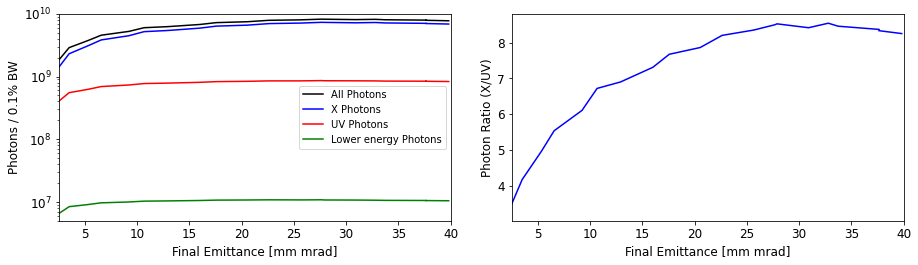

In [27]:
fig,axs = plt.subplots(1, 2, figsize=(13,4))
fig.tight_layout(pad=3.) #set the spacing between subplots

ax = axs[0]
ax.plot(emittances, all_photons,c='k', label = 'All Photons') # photon number ~ beta oscillations * number of electrons
ax.plot(emittances, x_photons,c='b', label = 'X Photons') # photon number ~ beta oscillations * number of electrons
ax.plot(emittances, uv_photons,c='r', label = 'UV Photons') # photon number ~ beta oscillations * number of electrons
ax.plot(emittances, low_photons,c='g', label = 'Lower energy Photons') # photon number ~ beta oscillations * number of electrons


ax.set_yscale('log')


ax.set_xlabel('Final Emittance [mm mrad]', fontsize=fontsize)
ax.set_ylabel('Photons / 0.1% BW', fontsize=fontsize)
ax.tick_params(axis='both',labelsize=fontsize)
ax.set_ylim(5e6,1e10)
ax.set_xlim(2.5, 40)
#ax.set_xlim(1e0,4e4)

#ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
locmin = ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=15)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.legend(loc='center right')


ax = axs[1]
x_uv_photons = [x / y for x, y in zip(x_photons, uv_photons)]
x_low_photons = [x / y for x, y in zip(x_photons, low_photons)]
uv_low_photons = [x / y for x, y in zip(uv_photons, low_photons)]




ax.plot(emittances, x_uv_photons,c='b', label='x/uv') # photon number ~ beta oscillations * number of electrons

#ax.set_yscale('log')


ax.set_xlabel('Final Emittance [mm mrad]', fontsize=fontsize)
ax.set_ylabel('Photon Ratio (X/UV)', fontsize=fontsize)
ax.tick_params(axis='both',labelsize=fontsize)
#ax.set_ylim(5e6,1e10)
#ax.set_xlim(1e0,4e4)

#ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
#ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
locmin = ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=15)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(ticker.NullFormatter())
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(ticker.NullFormatter())
#plt.legend(loc='lower right')
ax.set_xlim(2.5, 40)

fig.savefig("synchrotron-emittanceCorrelation-photons.pdf", dpi=100, bbox_inches='tight')
fig.savefig("synchrotron-emittanceCorrelation-photons.png", dpi=100, bbox_inches='tight')

## radiation divergence vs emittance

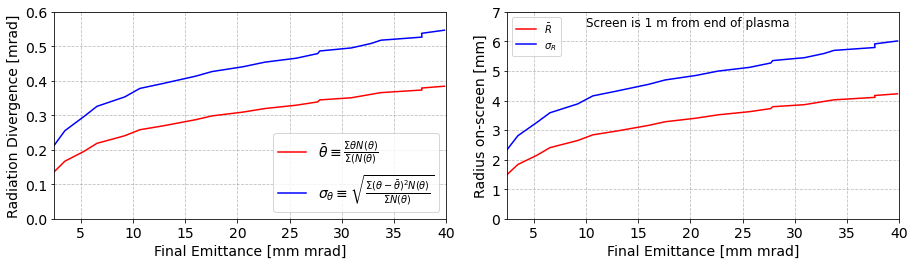

In [39]:
fig,axs = plt.subplots(1, 2, figsize=(13,4))
fig.tight_layout(pad=3.) #set the spacing between subplots

ax = axs[0]
meanThetas1 = [theta * 1000 for theta in meanThetas]
sigmaThetas1 = [theta * 1000 for theta in sigmaThetas]

ax.plot(emittances, meanThetas1,c='r', label = r'$\bar{\theta}  \equiv \frac{\Sigma \theta N(\theta)}{\Sigma(N(\theta)}$') # photon number ~ beta oscillations * number of electrons
ax.plot(emittances, sigmaThetas1,c='b', label = r'$\sigma_\theta  \equiv \sqrt{ \frac{\Sigma (\theta - \bar{\theta})^2 N(\theta)}{\Sigma N(\theta)} }$') # photon number ~ beta oscillations * number of electrons



ax.set_xlabel('Final Emittance [mm mrad]', fontsize=fontsize)
ax.set_ylabel('Radiation Divergence [mrad]', fontsize=fontsize)

ax.tick_params(axis='both',labelsize=fontsize)
#ax.set_ylim(5e6,1e10)
ax.set_xlim(2.5, 40)
ax.set_ylim(0, .6)
#ax.set_xlim(1e0,4e4)

#ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
#ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
#locmin = ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=15)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(ticker.NullFormatter())
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.legend(loc='lower right', fontsize=14)
ax.grid(True, linestyle='--', color='gray', alpha=0.5)

ax = axs[1]
###########
# screen is 1 metre after plasma 

screen_position = 11
R = [theta * 1000 * screen_position for theta in meanThetas] # [mm] min radius if end of plasma and screen are 1 metre apart
sigma_R = [theta * 1000 * screen_position for theta in sigmaThetas] # [mm]

ax.plot(emittances, R,c='r', label = r'$\bar{R}$') # photon number ~ beta oscillations * number of electrons
ax.plot(emittances, sigma_R,c='b', label = r'$\sigma_{R}$') # photon number ~ beta oscillations * number of electrons


ax.set_xlabel('Final Emittance [mm mrad]', fontsize=fontsize)
ax.set_ylabel('Radius on-screen [mm]', fontsize=fontsize)
ax.tick_params(axis='both',labelsize=fontsize)
#ax.set_ylim(5e6,1e10)
#ax.set_xlim(1e0,4e4)

#ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
#ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
locmin = ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=15)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(ticker.NullFormatter())
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(ticker.NullFormatter())
plt.legend(loc='upper left')
ax.set_xlim(2.5, 40)
ax.set_ylim(0, 7)
ax.grid(True, linestyle='--', color='gray', alpha=0.5)

ax.text(0.2, 0.98, 'Screen is 1 m from end of plasma', transform=ax.transAxes, fontsize = 12, va='top', color='k')
fig.savefig("synchrotron-emittanceCorrelation-theta.pdf", dpi=100, bbox_inches='tight')
fig.savefig("synchrotron-emittanceCorrelation-theta.png", dpi=100, bbox_inches='tight')